In [43]:
from os import path
import matplotlib.pyplot as plt

from pyedflib import highlevel
import pyedflib

import numpy as np
import pandas as pd
from jupyterthemes import jtplot

%matplotlib inline

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')

In [200]:
data_dir = path.join('..', 'data', 'psg_audio')

dataset_name = '00001178-100507'
audio_file_name = f'{dataset_name}.edf'
snore_annotation_file_name = path.join('snore_annotations', f'{dataset_name}.csv')

# header = highlevel.read_edf_header(path.join(data_dir, audio_file_name))

In [201]:
snore_annotations = pd.read_csv(path.join(data_dir, snore_annotation_file_name))

print('# of snoring events:', len(snore_annotations))
snore_annotations.head()

# of snoring events: 237


Start  Duration
0  1524.5      11.5
1  1863.5       4.0
2  2034.5       5.0
3  2046.0       4.5
4  2083.0       4.5

In [4]:
with pyedflib.EdfReader(path.join(data_dir, audio_file_name)) as f:
    header = f.getSignalHeaders()
    sample_rate = header[0]['sample_rate']

    # the number of signals
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()

    print(signal_labels, f.getNSamples() / sample_rate / 3600)
    print(header, sample_rate)

['Mic'] [4.12472222]
[{'label': 'Mic', 'dimension': '', 'sample_rate': 48000.0, 'sample_frequency': 48000.0, 'physical_max': 1.0, 'physical_min': -1.0, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': '', 'transducer': ''}] 48000.0


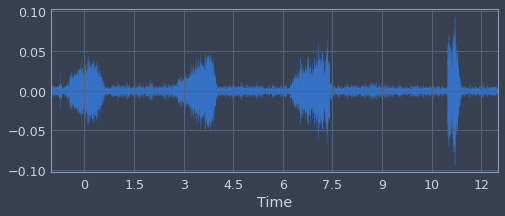

In [5]:
import IPython.display as ipd
import librosa.display

start, duration = snore_annotations.iloc[0]

start -= 1
duration += 2

with pyedflib.EdfReader(path.join(data_dir, audio_file_name)) as f:
    header = f.getSignalHeaders()
    sample_rate = header[0]['sample_rate']

    audio_signal = f.readSignal(0, int(start * sample_rate), int(duration * sample_rate))

fig, ax = plt.subplots(figsize=(8, 3))

ax.set(xlim=(-1, -1 + duration))
librosa.display.waveshow(audio_signal, sr=sample_rate, offset=-1, x_axis='time', ax=ax)

# ipd.Audio(audio_signal, rate=sample_rate)


In [23]:
edf_file = '../data/psg_audio/00001178-100507.edf'
csv_file = '../data/psg_audio/snore_annotations/00001178-100507.csv'

def load_test():
    with pyedflib.EdfReader(edf_file) as f:
        n_samples = f.getNSamples()[0]
        header = f.getSignalHeaders()
        sample_rate = header[0]['sample_rate']
    
        audio_signals = f.readSignal(0, 0, int(10 * sample_rate))

%timeit load_test()

174 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [195]:
from os import path

import numpy as np
import pandas as pd

import pyedflib
import librosa
from librosa.feature import mfcc


def segments_labels(dataset_name):
    ms = 1e-3
    edf_file = f'../data/psg_audio/{dataset_name}.edf'
    csv_file = f'../data/psg_audio/snore_annotations/{dataset_name}.csv'

    snore_annotations = pd.read_csv(csv_file)

    with pyedflib.EdfReader(edf_file) as f:
        n_samples = f.getNSamples()[0]
        header = f.getSignalHeaders()
        sample_rate = header[0]['sample_rate']

        seg_step = 0.25
        seg_duration = 5
        noise_margin = 30.0
        n_steps = int(np.floor(((n_samples / sample_rate - seg_duration) / seg_step)))
        psg_duration = n_steps * seg_step

        xs = np.linspace(0, psg_duration, n_steps, endpoint=False)

        snore_durations = pd.concat([pd.DataFrame([[-seg_duration, 0]], columns=['Start', 'Duration']),
                                     snore_annotations,
                                     pd.DataFrame([[n_samples / sample_rate + seg_duration, 0]],
                                                  columns=['Start', 'Duration'])])

        idx_a = idx_b = 0
        start_a, duration_a = snore_durations.iloc[idx_a]
        end_a = start_a + duration_a
        start_b, duration_b = snore_durations.iloc[idx_b]
        end_b = start_b + duration_b

        segments = []
        labels = []

        for idx, x in enumerate(xs):
            while end_a < x:
                idx_a += 1
                start_a, duration_a = snore_durations.iloc[idx_a]
                end_a = start_a + duration_a

            while start_b < x + seg_duration:
                idx_b += 1
                start_b, duration_b = snore_durations.iloc[idx_b]
                end_b = start_b + duration_b

            # i < idx_a => (end < x) => no overlapps
            # i >= idx_b => (start >= x + seg_duration) => no overlapps
            # only need to check i such that idx_a <= i < idx_b

            max_overlap = 0.0

            if idx_a >= idx_b:
                ls, ld = snore_durations.iloc[idx_a - 1]
                le = ls + ld
                rs, rd = snore_durations.iloc[idx_a]
                re = rs + rd

                dist = min(x - le, rs - x + seg_duration)
                if dist > noise_margin:
                    segments.append((x, x + seg_duration))
                    labels.append(0)
            else:
                for i in range(idx_a, idx_b):
                    s, d = snore_durations.iloc[i]
                    e = s + d
                    if s < x and x + seg_duration < e:
                        max_overlap = seg_duration
                        break
                    elif x < s and e < x + seg_duration:
                        overlap = e - s
                    else:
                        overlap = min(e - x, x + seg_duration - s)

                    if overlap > max_overlap:
                        max_overlap = overlap

                if max_overlap >= 4.0:
                    segments.append((x, x + seg_duration))
                    labels.append(1)

            if idx % 1000 == 0:
                print(f'{idx + 1:5d} / {len(xs):5d}', end='\r')

    return segments, labels


In [300]:
dataset_name = '00001171-100507'
dataset_name = '00001178-100507'

segments, labels = segments_labels(dataset_name)
print()
print(len(segments), len(labels))
print(np.mean(labels))

59001 / 59376
33948 33948
0.22858489454459763


#### calculating mfcc features and labels for segments
- it assumes that edf audio signals are copied to a hdf5 file
    - `audio` dataset

In [104]:
import h5py
from librosa.feature import mfcc


def mfcc_label(hdf5_file, segments, labels):
    ms = 1e-3
    hop_length = int(31.27 * ms * sample_rate)
    n_fft = int(np.ceil(50 * ms * sample_rate / 512) * 512)
    n_mfcc = 32

    with h5py.File(hdf5_file, mode='r+') as h5_file:
        audio = h5_file['audio']
        sample_reate = audio.attrs['sample_rate']

        # 160 frames with 31.27 ms of hop length is about 5 seconds
        mfcc_ds = h5_file.require_dataset('mfcc', shape=(len(segments), n_mfcc, 160), dtype=np.float32)

        for i, (seg_start, seg_end) in enumerate(segments):
            seg_start_idx = int(seg_start * sample_rate)
            seg_end_idx = int(seg_end * sample_rate)

            # fs.shape = (n_mfcc, # of frames)
            fs = mfcc(y=(audio[seg_start_idx:seg_end_idx] / (1 << 15)).astype(dtype=np.float32),
                      sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
            mfcc_ds[i, ...] = fs[:, :160]

            if i % 100 == 0:
                print(f'{i + 1:4d} / {len(segments):4d}', end='\r')
        
        label_ds = h5_file.require_dataset('label', shape=(len(segments),), dtype=np.float32)
        label_ds[...] = labels
        
        segment_ds = h5_file.require_dataset('segment', shape=(len(segments), 2), dtype=np.int64)
        segment_ds[...] = np.asarray(segments) * sample_rate

In [114]:
h5_file_name = '00001171-100507.h5'
h5_file_name = '00001178-100507.h5'

segments, labels = segments_labels(dataset_name)
mfcc_label(h5_file_name, segments, labels)


[5917 5918 5919 5920 5921 5922 5923 5924 5925 5926 5927 5928 5929 5930
 5931 7021 7022 7023 7024 7025]
label: 1
snore start: -4.0, snore end: 7.5


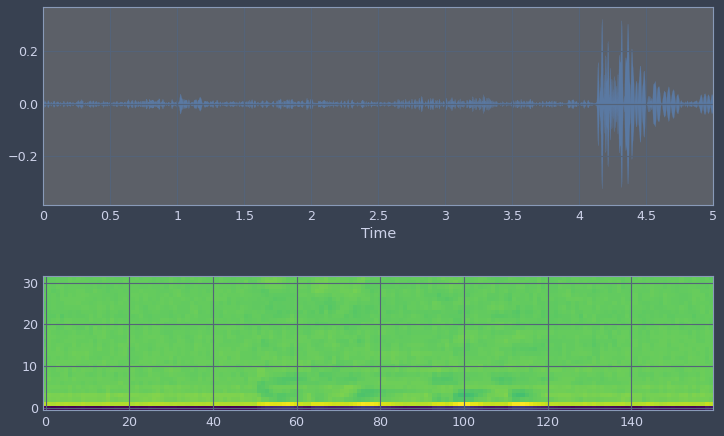

In [203]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import librosa.display


print(np.where([l == 1 for l in labels])[0][20:40])

snore_durations = pd.concat([pd.DataFrame([[-seg_duration, 0]], columns=['Start', 'Duration']),
                             snore_annotations,
                             pd.DataFrame([[n_samples / sample_rate + seg_duration, 0]],
                                          columns=['Start', 'Duration'])])
snore_durations['End'] = snore_durations['Start'] + snore_durations['Duration']
# print(snore_durations.head())

fig, (ax_raw, ax_mfcc) = plt.subplots(2, 1, figsize=(12, 8))

with h5py.File(h5_file_name, mode='r') as h5_file:
    idx = 5917
    seg_start, seg_end = segments[idx]
    print('label:', labels[idx])

    a = snore_durations[snore_durations['Start'] < seg_end]
    a = a[a['End'] > seg_start]
    
    for _, row in a.iterrows():
        snore_start, snore_end = row[0] - seg_start, row[2] - seg_start
        print(f'snore start: {snore_start}, snore end: {snore_end}')
        box = Rectangle((snore_start, -1), snore_end - snore_start, 2, fc='grey', alpha=0.5)
        ax_raw.add_patch(box)
    
    seg_start_idx, seg_end_idx = int(seg_start * sample_rate), int(seg_end * sample_rate)
    
    
    audio_signal = h5_file['audio'][seg_start_idx:seg_end_idx] / (1 << 15)
    librosa.display.waveshow(audio_signal, sr=sample_rate, x_axis='time', ax=ax_raw)
    ax_raw.set_xlim(0, seg_end - seg_start)
    audio_min, audio_max = np.min(audio_signal), np.max(audio_signal)
    ax_raw.set_ylim(1.1 * audio_min - 0.1 * audio_max, 1.1 * audio_max - 0.1 * audio_min)
    
    ax_mfcc.imshow(h5_file['mfcc'][idx], origin='lower')


In [118]:
import sys
sys.path.append(path.join('../', 'src'))

import torch
from model_khan import SnoreModel


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SnoreModel().to(device)
model.load_state_dict(torch.load(path.join('..', 'snore_detection', 'snore_model_epoch_50.pt')))
model.eval()

SnoreModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do2): Dropout2d(p=0.25, inplace=False)
  (d1): Linear(in_features=2304, out_features=512, bias=True)
  (do3): Dropout(p=0.5, inplace=False)
  (d2): Linear(in_features=512, out_features=64, bias=True)
  (d3): Linear(in_features=64, out_features=1, bias=True)
)

In [204]:
import librosa
from librosa.feature import mfcc

from skimage.util import view_as_windows


ms = 1e-3
hop_length = int(31.27 * ms * sample_rate)
n_fft = int(np.ceil(50 * ms * sample_rate / 512) * 512)
n_mfcc = 32

preds = []

with h5py.File(h5_file_name, mode='r') as h5_file:
    audio = h5_file['audio']
    for i, (start, duration) in enumerate(zip(snore_annotations.Start, snore_annotations.Duration)):
        audio_signal = audio[int(start * sample_rate):int((start + duration) * sample_rate)]
        norm_audio = audio_signal / max(np.max(np.abs(audio_signal)), 0.001)
        features = mfcc(y=norm_audio, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

        if features.shape[1] < 32:
            continue

        with torch.no_grad():
            # only 1 window for row. So squeeze()
            batch = view_as_windows(features, (32, 32), (32, 4)).squeeze()
            batch = torch.tensor(batch).unsqueeze(dim=1).float().to(device)
            score = torch.max(model(batch)).item()
            preds.append(score)
        
        print(f'{i + 1:4d} / {len(snore_annotations):4d}', end='\r')

    preds = np.asarray(preds)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (85x2304 and 14592x512)

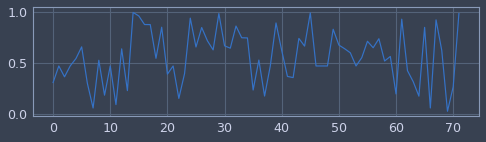

In [121]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(preds)

In [124]:
import IPython.display as ipd


idx = np.where(preds < 0.5)[0][-10]
print(idx, preds[idx])

start, duration = snore_annotations.iloc[idx]
with h5py.File(h5_file_name, mode='r') as h5_file:
    audio_signal = h5_file['audio'][int(start * sample_rate): int((start + duration) * sample_rate)]

ipd.Audio(audio_signal, rate=sample_rate, autoplay=True)

47 0.4700455665588379


47 0.4700455665588379


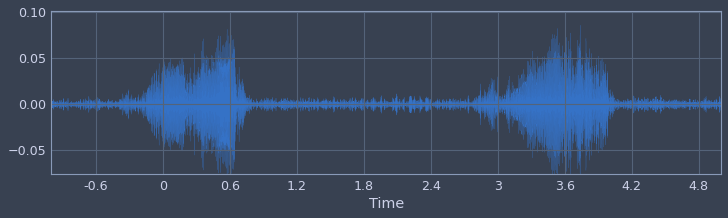

In [126]:
import librosa.display

idx = np.where(preds < 0.5)[0][-10]
print(idx, preds[idx])

start, duration = snore_annotations.iloc[idx]

with h5py.File(h5_file_name, mode='r') as h5_file:
    start_idx = int((start - 1) * sample_rate)
    end_idx = int((start + duration + 1) * sample_rate)
    audio_signal = h5_file['audio'][start_idx:end_idx] / (1 << 15)

fig, ax = plt.subplots(figsize=(12, 3))
librosa.display.waveshow(audio_signal, sr=sample_rate, offset=-1, x_axis='time', ax=ax)
ax.set_xlim(-1, duration + 1)

audio_min, audio_max = np.min(audio_signal), np.max(audio_signal)
ax.set_ylim(1.1 * audio_min - 0.1 * audio_max, 1.1 * audio_max - 0.1 * audio_min)
    
ax.grid(True)

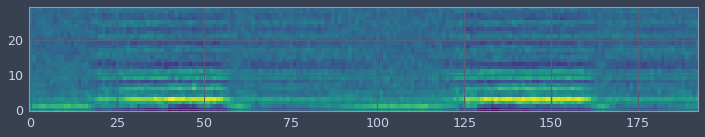

In [127]:
features = mfcc(y=audio_signal, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
# batch = view_as_windows(features, (32, 32), (32, 4)).squeeze()
# batch = torch.tensor(batch).unsqueeze(dim=1).float().to(device)
# model(batch)

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(features[2:], origin='lower', interpolation='nearest')

5417


(0.0, 5.0)

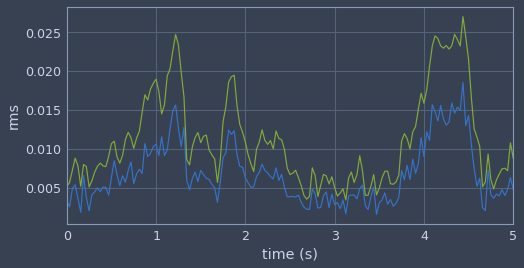

In [92]:
import librosa.feature


h5_file_name = '00001171-100507.h5'
h5_file_name = '00001178-100507.h5'

with h5py.File(h5_file_name, mode='r') as h5_file:
    l = h5_file['label'][...]
    snore_indice = np.where(l == 1)[0]
    print(snore_indice[0])
    
    start, end = h5_file['segment'][snore_indice[0]]
    audio_signal = h5_file['audio'][start:end] / (1 << 15)

spec = librosa.stft(audio_signal, hop_length=hop_length, n_fft=n_fft)
rms = librosa.feature.rms(S=spec, hop_length=hop_length, frame_length=n_fft)
rms_raw = librosa.feature.rms(y=audio_signal, hop_length=hop_length, frame_length=n_fft)

times = librosa.times_like(rms, sr=sample_rate, hop_length=hop_length)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(times, rms[0])
ax.plot(times, rms_raw[0])

ax.set_xlabel('time (s)')
ax.set_ylabel('rms')

ax.set_xlim(times[0], times[-1])

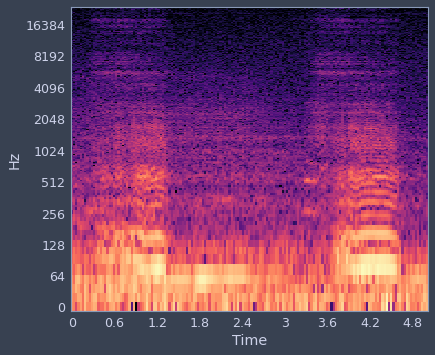

In [128]:
fig, ax = plt.subplots()

mag, _ = librosa.magphase(spec)
librosa.display.specshow(librosa.amplitude_to_db(mag, ref=np.max),
                         sr=sample_rate, hop_length=hop_length, n_fft=n_fft,
                         y_axis='log', x_axis='time', ax=ax)


#### CQT spectrogram

00001178-100507.h5
5897
(84, 161)


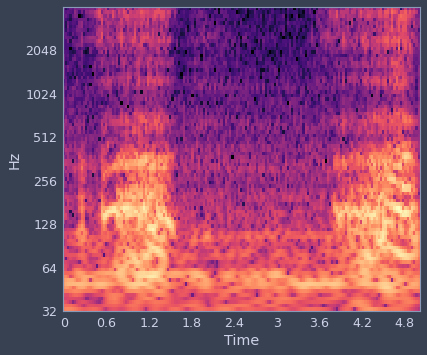

In [302]:
fig, ax = plt.subplots()


h5_file_name = '00001171-100507.h5'
h5_file_name = '00001178-100507.h5'

print(h5_file_name)

with h5py.File(h5_file_name, mode='r') as h5_file:
    l = h5_file['label'][...]
    snore_indice = np.where(l == 1)[0]
    print(snore_indice[0])
    
    start, end = h5_file['segment'][snore_indice[0]]
    audio_signal = h5_file['audio'][start:end] / (1 << 15)

spec = librosa.cqt(y=audio_signal, sr=sample_rate, hop_length=hop_length)
mag, _ = librosa.magphase(spec)
print(mag.shape)

librosa.display.specshow(librosa.amplitude_to_db(mag, ref=np.max),
                         sr=sample_rate, hop_length=hop_length, n_fft=n_fft,
                         y_axis='cqt_hz', x_axis='time', ax=ax)

In [303]:
import torch
import torch.nn as nn
from torch.nn import functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class SnoreModel(nn.Module):
    def __init__(self):
        super().__init__()

        # modified Kahn (2019) architecture
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.do1 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.do2 = nn.Dropout2d(0.25)

        # fully connected
        self.d1 = nn.Linear(14592, 512)
        self.do3 = nn.Dropout(0.5)
        self.d2 = nn.Linear(512, 64)
        self.d3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.do1(self.maxpool1(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.do2(self.maxpool2(x))
        x = F.relu(self.d1(x.view(x.size(0), -1)))
        x = F.relu(self.d2(self.do3(x)))
        x = torch.sigmoid(self.d3(x))

        return x


#### How to normalize MFCC
- `StandardScaler.fit` for all training MFCC first
- and construct a custome `Dataset`
- scales of the first 2 MFCC features are much bigger

00001178-100507.h5


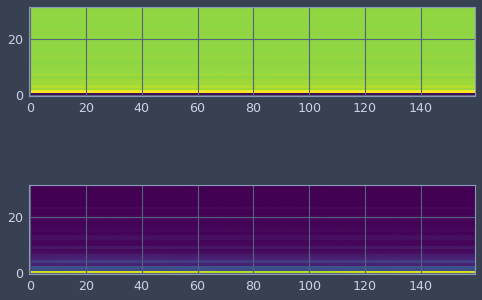

In [304]:
import h5py
from sklearn.preprocessing import StandardScaler


# h5_file_name = '00001171-100507.h5'
print(h5_file_name)

with h5py.File(h5_file_name, mode='r') as h5_file:
    scaler = StandardScaler()
    scaler.fit(h5_file['mfcc'][...].reshape(-1, 32 * 160))

fig, (ax_mean, ax_scale) = plt.subplots(2, 1, figsize=(8, 6))

ax_mean.imshow(scaler.mean_.reshape(-1, 160), origin='lower', interpolation='nearest')
ax_scale.imshow(scaler.scale_.reshape(-1, 160), origin='lower', interpolation='nearest')


#### normalized MFCC
- it is easier to see the difference between snore and non-snore

00001178-100507.h5
9284


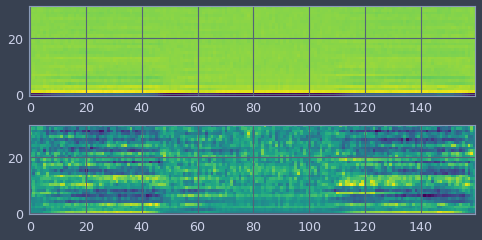

In [305]:
# h5_file_name = '00001171-100507.h5'


fig, (ax_raw, ax_norm) = plt.subplots(2, 1, figsize=(8, 4))

print(h5_file_name)
with h5py.File(h5_file_name, mode='r') as h5_file:
    l = h5_file['label'][...]
    
    snore_idx = np.where(l == 1)[0][700]
    print(snore_idx)
    
    mfcc = h5_file['mfcc'][snore_idx].reshape(1, -1)
    norm_mfcc = scaler.transform(mfcc)
    
    ax_norm.imshow(norm_mfcc.reshape(32, -1), origin='lower', interpolation='nearest')
    ax_raw.imshow(mfcc.reshape(32, -1), origin='lower', interpolation='nearest')


In [320]:
from torch.utils.data import Dataset, DataLoader
import torch.optim

from sklearn.model_selection import train_test_split


class SnoreDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.unsqueeze(torch.tensor(x).float(), dim=1)
        self.y = torch.unsqueeze(torch.tensor(y).float(), dim=1)
    
    def __len__(self):
        return self.x.shape[0]s
    
    def __getitem__(self, ix):
        tx = scaler.transform(self.x[ix].view(-1, 32 * 160)).reshape(1, 32, 160)
        tx = torch.Tensor(tx).float().to(device)
        return tx, self.y[ix]
#         return self.x[ix], self.y[ix]


def get_model():
    model = SnoreModel().to(device)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    return model, loss_fn, optimizer


def get_data(file_name):
    with h5py.File(file_name, mode='r') as h5_file:
        x = h5_file['mfcc'][...]
        y = h5_file['label'][...]

#     train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.1)
    
    n_samples = x.shape[0]
    n_trains = int(n_samples * 0.8)
    train_x = x[:n_trains]
    valid_x = x[n_trains:]
    train_y = y[:n_trains]
    valid_y = y[n_trains:]
    
    train_dl = DataLoader(SnoreDataset(train_x, train_y), batch_size=16, shuffle=True)
    valid_dl = DataLoader(SnoreDataset(valid_x, valid_y), batch_size=16, shuffle=True)
    
    return train_dl, valid_dl


@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x.to(device))
    is_correct = (prediction > 0.5) == y.to(device)
    
    return is_correct.cpu().numpy().squeeze()

#### training
- initialize a model
- `sample` and `label` from a hdf5 file
- using `segment` you can get raw audio signals from `audio`

In [321]:
from torch_snippets import Report


train_dl, valid_dl = get_data(h5_file_name)
model, loss_fn, optimizer = get_model()


def train_batch(inputs, model, optimizer, criterion):
    model.train()
    batch_x, batch_y = inputs
    
    x = batch_x.to(device)
    y = batch_y.to(device)

    pred_y = model(x)
    optimizer.zero_grad()
    loss = criterion(pred_y, y)
    loss.backward()
    optimizer.step()
    
    return loss.item()


@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    batch_x, batch_y = inputs
    
    x = batch_x.to(device)
    y = batch_y.to(device)
    
    pred_y = model(x)
    loss = criterion(pred_y, y)
    
    return loss.item()


#### checking few HDF5 `label` dataset
- I tried 10 or so.
- `label` seems to be correct

In [322]:
with h5py.File(h5_file_name, mode='r') as h5_file:
    label = h5_file['label'][...]
    segment = h5_file['segment']
    audio = h5_file['audio']
    sample_rate = audio.attrs['sample_rate']
    
    idx = np.where(label == 1.0)[0][315]
    
    audio_signal = audio[segment[idx][0]:segment[idx][1]] / (1 << 15)


ipd.Audio(audio_signal, rate=sample_rate, autoplay=True)

EPOCH: 20.000	val_loss: 0.015	val_acc: 1.000	(524.51s - 0.00s remaining))))

100%|████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 161.39it/s]


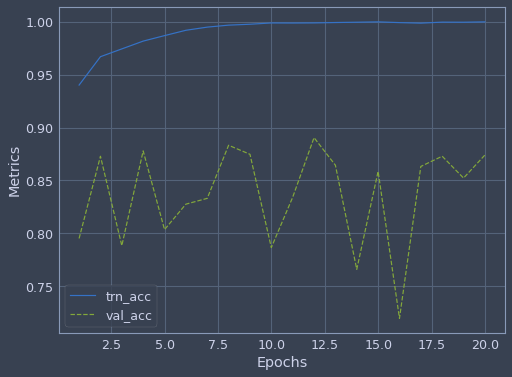

In [323]:
n_epochs = 20
log = Report(n_epochs)

for epoch in range(n_epochs):
    _n = len(train_dl)
    for ix, (batch_x, batch_y) in enumerate(train_dl):
        loss = train_batch((batch_x, batch_y), model, optimizer, loss_fn)
        mean_acc = accuracy(batch_x, batch_y, model).mean()
        pos = epoch + (ix + 1) / _n
        log.record(pos, trn_loss=loss, trn_acc=mean_acc, end='\r')
    
    _n = len(valid_dl)
    for ix, (batch_x, batch_y) in enumerate(valid_dl):
        loss = validate_batch((batch_x, batch_y), model, loss_fn)
        mean_acc = accuracy(batch_x, batch_y, model).mean()
        pos = epoch + (ix + 1) / _n
        log.record(pos, val_loss=loss, val_acc=mean_acc, end='\r')

log.plot_epochs(['trn_acc', 'val_acc'])

100%|████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 164.22it/s]


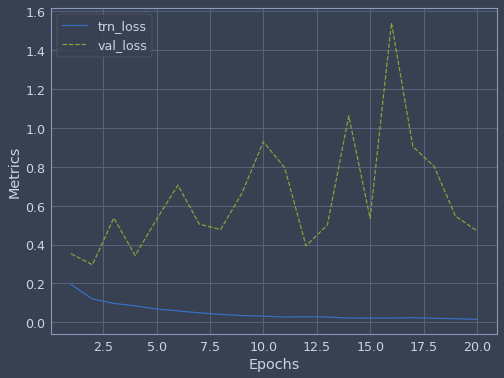

In [324]:
log.plot_epochs(['trn_loss', 'val_loss'])

/tmp/ipykernel_6388/2933082444.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf